In [1]:
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
torch.__version__

'1.8.1'

In [2]:
USE_CUDA    = torch.cuda.is_available()
DEVICE      = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS      = 300
BATCH_SIZE  = 1460

In [3]:
sample = pd.read_csv("data/coin_Bitcoin_Full.csv")
sample.drop(['Tommorow_Close','Tommorow_IncRatio','Tommorow_Pos'],axis='columns')

,Date,High,Low,Open,Close,Volume,MA200,EMA130,PercentB20,RSI14,MFI14,MACD,fast_k,slow_d
0,2017-01-01,1003.080017,958.698975,963.658020,998.325012,1.477750e+08,676.439377,726.854930,0.896990,0.859802,0.789506,-73.609344,0.977651,0.934168
1,2017-01-02,1031.390015,996.702026,998.617004,1021.750000,2.221850e+08,677.716587,731.357145,0.913535,0.869408,0.805343,-76.362399,0.959815,0.951889
2,2017-01-03,1044.079956,1021.599976,1021.599976,1043.839966,1.851680e+08,679.191241,736.127876,0.921943,0.875023,0.814751,-79.333322,0.999019,0.978828
3,2017-01-04,1159.420044,1044.400024,1044.400024,1154.729980,3.449460e+08,681.183756,742.518748,1.098171,0.899147,0.833259,-84.066016,0.985581,0.981472
4,2017-01-05,1191.099976,910.416992,1156.729980,1013.380005,5.101990e+08,682.431751,746.654034,0.722185,0.645207,0.673515,-86.055164,0.459285,0.814628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2020-12-26,26718.070893,24522.689482,24677.016056,26437.037509,4.833265e+10,12929.903141,15766.746562,0.976863,0.851761,0.920118,-2997.597949,0.964799,0.962039
1456,2020-12-27,28288.840022,25922.769765,26439.373289,26272.294567,6.647990e+10,13011.914142,15927.136608,0.903582,0.833914,0.927265,-3083.370200,0.782609,0.913536
1457,2020-12-28,27389.112064,26207.639931,26280.821415,27084.807886,4.905674e+10,13100.729275,16097.482734,0.919669,0.844247,0.931462,-3177.755257,0.869255,0.872221
1458,2020-12-29,27370.720084,25987.298075,27081.809729,27362.436557,4.526595e+10,13190.137239,16269.466762,0.894310,0.845700,0.934446,-3270.925280,0.896958,0.849607


In [4]:
from datetime import datetime
# make train_loader and test_loader
sample = sample[['Date', 'High', 'Low', 'Open', 'Close', 'Volume','MA200','EMA130','PercentB20','RSI14','MFI14','MACD','fast_k','slow_d']]
sample['Label'] = ""
sample['Up']= np.nan
sample['Down'] = np.nan
for idx in sample.index:
    # no information for the last day
    if idx == sample.index[-1]:
        continue
    
    if sample.shift(-1).loc[idx, 'Close'] > sample.shift(-1).loc[idx, 'Open']:
        sample.loc[idx, 'Label'] = "UP" 
        sample.loc[idx, 'Up'] = 1
        sample.loc[idx, 'Down'] = 0. 
    else:
        sample.loc[idx, 'Label'] = "DOWN" 
        sample.loc[idx, 'Up'] = 0.
        sample.loc[idx, 'Down'] = 1.
    date = sample.loc[idx, 'Date']
    sample.loc[idx, 'Date'] = datetime.strptime(date, '%Y-%m-%d').date()
sample = sample.set_index('Date')
sample.tail() 

,High,Low,Open,Close,Volume,MA200,EMA130,PercentB20,RSI14,MFI14,MACD,fast_k,slow_d,Label,Up,Down
Date,,,,,,,,,,,,,,,,
2020-12-26,26718.070893,24522.689482,24677.016056,26437.037509,4.833265e+10,12929.903141,15766.746562,0.976863,0.851761,0.920118,-2997.597949,0.964799,0.962039,DOWN,0.0,1.0
2020-12-27,28288.840022,25922.769765,26439.373289,26272.294567,6.647990e+10,13011.914142,15927.136608,0.903582,0.833914,0.927265,-3083.370200,0.782609,0.913536,UP,1.0,0.0
2020-12-28,27389.112064,26207.639931,26280.821415,27084.807886,4.905674e+10,13100.729275,16097.482734,0.919669,0.844247,0.931462,-3177.755257,0.869255,0.872221,UP,1.0,0.0
2020-12-29,27370.720084,25987.298075,27081.809729,27362.436557,4.526595e+10,13190.137239,16269.466762,0.894310,0.845700,0.934446,-3270.925280,0.896958,0.849607,UP,1.0,0.0
2020-12-30,28937.740004,27360.089709,27360.089709,28840.953420,5.128744e+10,13286.965619,16461.397856,0.955826,0.839918,0.936562,-3383.930625,0.987435,0.917883,,NaN,NaN


In [5]:
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2020-12-29', '%Y-%m-%d').date()
cut_date1 = datetime.strptime('2019-12-31', '%Y-%m-%d').date()
cut_date2 = datetime.strptime('2020-01-01', '%Y-%m-%d').date()

train_df = sample[start_date : cut_date1]
test_df = sample[cut_date2 :end_date]

In [6]:
X_features = ["High", "Low", "Open", "Close", "Volume",'MA200','EMA130','PercentB20','RSI14','MFI14','MACD','fast_k','slow_d']
Y_feature = ["Up"]

train_X_df, train_Y_df = train_df[X_features], train_df[Y_feature]
test_X_df, test_Y_df = test_df[X_features], test_df[Y_feature]

In [7]:
train_X = torch.from_numpy(train_X_df.astype('float64').to_numpy())
train_Y = torch.from_numpy(train_Y_df.astype('float64').to_numpy()).squeeze()
test_X = torch.from_numpy(test_X_df.astype('float64').to_numpy())
test_Y = torch.from_numpy(test_Y_df.astype('float64').to_numpy()).squeeze()

print(train_Y)

tensor([1., 1., 1.,  ..., 0., 0., 1.], dtype=torch.float64)


In [8]:
train = data_utils.TensorDataset(train_X, train_Y)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

test = data_utils.TensorDataset(test_X, test_Y)
test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, n_features, n_output=2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, n_output)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.dropout(x)

      x = F.relu(self.fc2(x))
      x = F.dropout(x)

      x = F.relu(self.fc3(x))
      x = F.dropout(x)

      x = F.relu(self.fc4(x))
      x = F.dropout(x)
    
      x = F.relu(self.fc5(x))
      x = F.dropout(x)
    
      x = self.fc6(x)
      return x

In [10]:
# change n_features and n_output with respect to the tensor shape
model = NeuralNet(n_features=13, n_output=2).to(DEVICE)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.05)

In [11]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.
    correct = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data.float())
        loss = F.cross_entropy(output, target.long())
        loss.backward()
        optimizer.step()

        # get train_loss and train_accuracy
        train_loss += F.cross_entropy(output, target.long(), reduction='sum').item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100.* correct/len(train_loader.dataset)
    return train_loss, train_accuracy

def evaluate(model, test_loader):
    # assume classification
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data.float())
            test_loss += F.cross_entropy(output, target.long(), reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
# train
history = dict()
history['train_loss'] = list()
history['train_acc'] = list()
history['test_loss'] = list()
history['test_acc'] = list()

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train(model, train_loader, optimizer, epoch=1)
    test_loss, test_acc = evaluate(model, test_loader)
    scheduler.step()
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    print(f"[{epoch}] Train Loss: {round(train_loss, 4)}, Train Accuracy: {round(train_acc, 2)}")
    print(f"[{epoch}] Test Loss : {round(test_loss, 4)}, Test Accuracy : {round(test_acc, 2)}\n")

[120] Train Loss: 16208289.0813, Train Accuracy: 53.88
[120] Test Loss : 69465493.0989, Test Accuracy : 51.37

[121] Train Loss: 17060242.1187, Train Accuracy: 50.78
[121] Test Loss : 73469991.3846, Test Accuracy : 48.08

[122] Train Loss: 19098703.4886, Train Accuracy: 50.78
[122] Test Loss : 88512067.5165, Test Accuracy : 47.53

[123] Train Loss: 20038563.4192, Train Accuracy: 49.32
[123] Test Loss : 77580614.3297, Test Accuracy : 46.98

[124] Train Loss: 18495033.5123, Train Accuracy: 50.23
[124] Test Loss : 81952604.8352, Test Accuracy : 50.82

[125] Train Loss: 19760635.7918, Train Accuracy: 49.41
[125] Test Loss : 72624341.8022, Test Accuracy : 51.1

[126] Train Loss: 17579893.5963, Train Accuracy: 49.68
[126] Test Loss : 70725519.4725, Test Accuracy : 48.63

[127] Train Loss: 18884946.5279, Train Accuracy: 49.04
[127] Test Loss : 71629233.2308, Test Accuracy : 53.85

[128] Train Loss: 18982378.9589, Train Accuracy: 48.49
[128] Test Loss : 81184638.5934, Test Accuracy : 50.0

[12

In [13]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1.-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

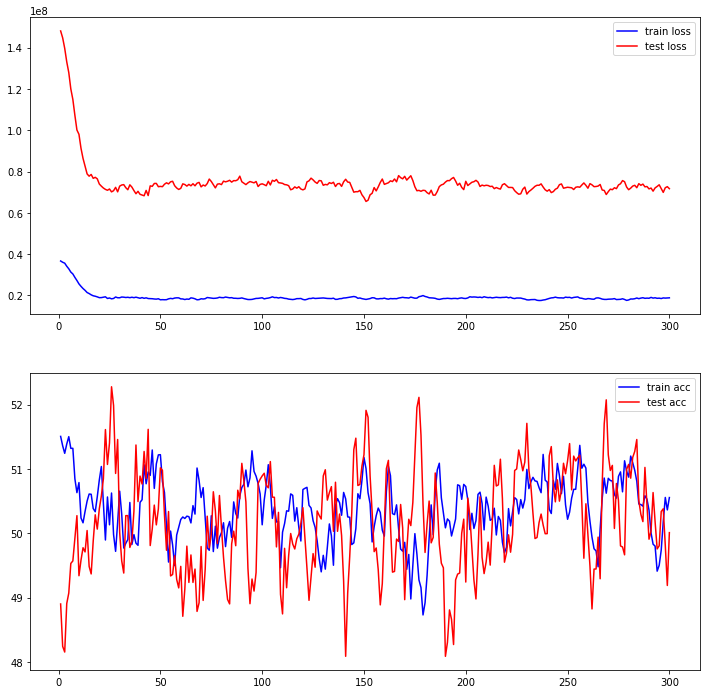

In [14]:
epochs = np.arange(1, EPOCHS+1)
train_loss = smooth_curve(np.array(history['train_loss']))
test_loss = smooth_curve(np.array(history['test_loss']))
train_acc = smooth_curve(np.array(history['train_acc']))
test_acc = smooth_curve(np.array(history['test_acc']))

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, "b", label="train loss")
plt.plot(epochs, test_loss, "r", label="test loss")
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, "b", label="train acc")
plt.plot(epochs, test_acc, "r", label="test acc")
plt.legend(loc='best')